# Compute Proponents/Opponents with Tracin

In [2]:
!/home/khmt/anaconda3/envs/soups-for-testing/bin/python --version

Python 3.10.18


In [3]:
%cd /home/khmt/Documents/TQKhangT/mthien/soups

/home/khmt/Documents/TQKhangT/mthien/soups


/home/khmt/anaconda3/envs/soups-for-testing/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import packages

In [4]:
%load_ext autoreload
%autoreload 2

In [71]:
import math
import os
from datetime import datetime
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

# import scienceplots  # noqa: F401
import torch
import torch.nn as nn
import torchvision
from captum.influence import TracInCPFast
from torch import Tensor
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import soups.utils as utils
from soups.utils.logger import init_logger, logger
from soups.utils.training import infer_final_fc, make_model

## Helper functions

In [72]:
def checkpoints_load_func(model: nn.Module, checkpoint_path: str, device: torch.device) -> float:
    """
    When this function is used in TracInCP implementations, this function should
    return the learning rate at the checkpoint. However, if that learning rate
    is not available, it is safe to simply return 1, as we do, because it turns
    out TracInCP implementations are not sensitive to that learning rate.
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return 1.0


def plot_accuracies(predicted_by_decreasing_self_influence_score: list[bool], show: bool = False, save_path: str | None = None) -> None:
    if save_path is not None and os.path.isfile(save_path):
        logger.error(f'Path for saving plot already exists: {save_path}')
        exit(0)

    plt.style.use(['science', 'no-latex'])
    plt.figure(figsize=(8, 6))
    increasing_scores_accuracies = []
    decreasing_scores_accuracies = []

    num_corrects = 0
    for i in range(len(predicted_by_decreasing_self_influence_score)):
        num_corrects += int(predicted_by_decreasing_self_influence_score[-i - 1])
        increasing_scores_accuracies.append(num_corrects / (i + 1))

    num_corrects = 0
    for i in range(len(predicted_by_decreasing_self_influence_score)):
        num_corrects += int(predicted_by_decreasing_self_influence_score[i])
        decreasing_scores_accuracies.append(num_corrects / (i + 1))

    plt.plot(increasing_scores_accuracies, label='Increasing self-influence scores', color='blue')
    plt.plot(decreasing_scores_accuracies, label='Decreasing self-influence scores', color='red')
    plt.xlabel('Number of examples considered')
    plt.ylabel('Cumulative Accuracy')

    plt.title('Model Accuracy vs Self-influence Score Order')
    plt.legend()
    plt.grid(True)

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logger.info(f'Saved accuracies plot to {save_path}')

    if show:
        plt.show()

def imshow_transform(tensor_in_dataset: Tensor) -> Tensor:
    return inverse_normalize_transform(tensor_in_dataset.squeeze()).permute(1, 2, 0)


def display_test_example(
    example: Tensor,
    true_label: int,
    predicted_label: int,
    predicted_prob: float,
    label_to_class: list[str],
):
    _fig, ax = plt.subplots()
    print('true_class:', label_to_class[true_label])
    print('predicted_class:', label_to_class[predicted_label])
    print('predicted_prob', predicted_prob)
    ax.imshow(torch.clip(imshow_transform(example), 0, 1))
    plt.show()


def display_training_examples(examples: list[Tensor] | Tensor, true_labels: list[int], label_to_class: list[str], figsize=(10, 4)):
    fig = plt.figure(figsize=figsize)
    num_examples = len(examples)
    for i in range(num_examples):
        ax = fig.add_subplot(1, num_examples, i + 1)
        ax.imshow(torch.clip(imshow_transform(examples[i]), 0, 1))
        ax.set_title(label_to_class[true_labels[i]], fontsize='9')
    plt.show()
    return fig


def display_proponents_and_opponents(
    test_examples_batch,
    proponents_indices,
    opponents_indices,
    test_examples_true_labels,
    test_examples_predicted_labels,
    test_examples_predicted_probs,
    label_to_class,
):
    for (
        test_example,
        test_example_proponents,
        test_example_opponents,
        test_example_true_label,
        test_example_predicted_label,
        test_example_predicted_prob,
    ) in zip(
        test_examples_batch,
        proponents_indices,
        opponents_indices,
        test_examples_true_labels,
        test_examples_predicted_labels,
        test_examples_predicted_probs,
        strict=True,
    ):
        print('test example:')
        display_test_example(
            example=test_example,
            true_label=test_example_true_label,
            predicted_label=test_example_predicted_label,
            predicted_prob=test_example_predicted_prob,
            label_to_class=label_to_class,
        )

        print('proponents:')
        test_example_proponents_tensors, test_example_proponents_labels = zip(
            *[train_dataset[i] for i in test_example_proponents], strict=True
        )
        display_training_examples(
            examples=test_example_proponents_tensors,
            true_labels=test_example_proponents_labels,
            label_to_class=label_to_class,
            figsize=(20, 8),
        )

        print('opponents:')
        test_example_opponents_tensors, test_example_opponents_labels = zip(
            *[train_dataset[i] for i in test_example_opponents], strict=True
        )
        display_training_examples(
            test_example_opponents_tensors,
            test_example_opponents_labels,
            label_to_class=label_to_class,
            figsize=(20, 8),
        )

def display_images_grid(
    examples: list[Tensor] | Tensor,
    true_labels: list[int],
    label_to_class: list[str],
    self_influence_scores: list[float] | None = None,
    max_cols: int = 4,
    figsize: tuple[int, int] | None = None,
    title_fontsize: int = 9,
):
    """Display images in a grid with at most max_cols images per row."""

    if isinstance(examples, Tensor):
        examples = [examples]

    num_examples = len(examples)
    if num_examples == 0:
        raise ValueError("No examples provided")

    cols = min(max_cols, num_examples)
    rows = math.ceil(num_examples / cols)

    if figsize is None:
        fig_width = cols * 3
        fig_height = rows * 3
        figsize = (fig_width, fig_height)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    # Handle case where we have only one subplot
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    for i in range(num_examples):
        ax = axes[i]

        ax.imshow(torch.clip(imshow_transform(examples[i]), 0, 1))

        title = label_to_class[true_labels[i]]
        if self_influence_scores is not None and i < len(self_influence_scores):
            title += f" ({self_influence_scores[i]:.3f})"

        ax.set_title(title, fontsize=title_fontsize)
        ax.axis('off')  # Remove axes for cleaner look

    for i in range(num_examples, len(axes)):
        axes[i].axis('off')

    plt.show()

    return fig


## TracIn

### Config

In [75]:
seed: int = 42
device_str: str = 'cpu'
output_file: str = './tracin_results.json'
model_name: str = 'timm/caformer_s36.sail_in22k_ft_in1k'
checkpoint_path_list: list[str] = [
    '/home/khmt/Documents/TQKhangT/mthien/soups/checkpoints-sync/2025-09-01_16-22-06-caformer_s36/f1/model_epoch_16_f1_0.7191.pth'
]
dataset_dir: str = './data/ich-split-renamed'
labels_file: str | None = './data/ich-split-renamed/labels_en.txt'
eval_batch_size: int = 8
num_workers: int = 1
max_num_train_samples = 1000
max_num_test_samples = 5


### Setup

In [8]:
init_logger(compact=True)

utils.set_seed(seed)
logger.info(f'Seed: {seed}')

if os.path.isfile(output_file):
    raise FileExistsError(f'Output file already exists: {output_file}')
os.makedirs(os.path.dirname(output_file), exist_ok=True)

if device_str == 'auto':
    device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_str)

logger.info(f'Using device: {device_str}')

# find all model checkpoint files
checkpoint_paths: list[str] = []
for checkpoint_path in checkpoint_path_list:
    if os.path.isfile(checkpoint_path) and checkpoint_path.endswith('.pth'):
        checkpoint_paths.append(checkpoint_path)
    elif os.path.isdir(checkpoint_path):
        checkpoint_paths.extend(
            os.path.join(checkpoint_path, f)
            for f in os.listdir(checkpoint_path)
            if f.endswith('.pth')
        )

if not checkpoint_paths:
    logger.error('No model checkpoints found.')
    exit(1)

logger.info(
    f'Found total {len(checkpoint_paths)} model checkpoints for calculating self-influence'
)

2025-09-17 20:54:15.638 | INFO     | 1535108138:4 - Seed: 42
2025-09-17 20:54:15.638 | INFO     | 1535108138:14 - Using device: cpu
2025-09-17 20:54:15.639 | INFO     | 1535108138:32 - Found total 1 model checkpoints for calculating self-influence


### Loading data and model

In [9]:
# transforms
normalize_transform = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

inverse_normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean=[0.0, 0.0, 0.0], std=[1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225]
    ),
    torchvision.transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0]),
])
eval_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    normalize_transform,
])

# loading dataset
train_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(dataset_dir, 'train'),
    transform=eval_transforms,
)
test_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(dataset_dir, 'test'),
    transform=eval_transforms,
)

train_dataset = torch.utils.data.Subset(
    dataset=train_dataset,
    indices=np.random.choice(
        len(train_dataset), min(len(train_dataset), max_num_train_samples), replace=False
    ),  # pyright: ignore[reportArgumentType]
)

test_dataset = torch.utils.data.Subset(
    dataset=test_dataset,
    indices=np.random.choice(
        len(test_dataset), min(len(test_dataset), max_num_test_samples), replace=False
    ),  # pyright: ignore[reportArgumentType]
)

# data loaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size=eval_batch_size,
    shuffle=False,
    # num_workers=num_workers,
)
test_data_loader = DataLoader(
    test_dataset,
    batch_size=eval_batch_size,
    shuffle=False,
    # num_workers=num_workers,
)
logger.info(f'{len(train_data_loader) = }, {len(test_data_loader) = }')

2025-09-17 20:54:15.658 | INFO     | 83858431:56 - len(train_data_loader) = 125, len(test_data_loader) = 1


In [76]:
# labels and class names
label_to_class = test_dataset.dataset.classes if isinstance(test_dataset, torch.utils.data.Subset) else test_dataset.classes
num_classes = len(label_to_class)

label_to_class_full = None
if labels_file is not None:
    with open(labels_file, 'r', encoding='utf-8') as f:
        label_full_names = [label.strip() for label in f.readlines() if label.strip()]
    label_to_class_full = ['?'] * num_classes

    # assume labels are 1-ok, 2-ok, ..., 17-ok
    for i, label in enumerate(label_to_class):
        label_idx = int(label.split('-')[0]) - 1
        assert label_idx >= 0 and label_idx < num_classes
        label_to_class_full[i] = label_full_names[label_idx]

    logger.info(f'{label_to_class_full = }')

2025-09-17 21:54:25.630 | INFO     | 1416763856:17 - label_to_class_full = ['Art of Don ca Tai tu music and song in southern Viet Nam', "Tam Vu's Alms Giving festival", 'The craft of building wooden boats in Long Dinh', 'Bamboo weaving', 'Ancestor worship ceremony', 'Bay Nui bull racing festival', 'Nghinh Ong festival', 'The Death Anniversary of National Hero Truong Dinh', 'Cai Rang floating market culture', 'Khmer Cham rieng cha pay art', 'Mat weaving', 'My Long Sea worship festival', 'Du Ke Theater Arts of the Khmer people', 'Khmer Ok Om Bok festival', 'Festival of Ba Chua Xu Goddess at Sam Mountain', 'Tan Phuoc Tay temple Ky Yen ceremony', 'Festival of the Five Elements Goddess']


In [11]:
# loading model
model = make_model(
    model_name=model_name,
    num_classes=num_classes,
).to(device)
model.eval()

final_fc_layer = infer_final_fc(model=model)
assert isinstance(final_fc_layer, nn.Linear)
logger.debug(f'final_fc_layer: {final_fc_layer = }')

2025-09-17 20:54:16.379 | DEBUG    | 1541995813:10 - final_fc_layer: final_fc_layer = Linear(in_features=2048, out_features=17, bias=True)


### Compute TracIn scores - TracInCPFast

In [12]:
tracin_cp_fast = TracInCPFast(
    model=model,
    final_fc_layer=final_fc_layer,
    train_dataset=train_data_loader,
    checkpoints=checkpoint_paths,
    checkpoints_load_func=partial(checkpoints_load_func, device=device),
    loss_fn=nn.CrossEntropyLoss(reduction='sum'),
)

#### Self-influence scores

In [13]:
start_time = datetime.now()
logger.info('Start computing self-influence scores...')
self_influence_scores = tracin_cp_fast.self_influence(show_progress=True)
total_minutes = (datetime.now() - start_time).total_seconds() / 60.0
print(
    'computed self influence scores for %d examples in %.2f minutes'
    % (len(self_influence_scores), total_minutes)
)

2025-09-17 20:54:16.409 | INFO     | 2942097534:2 - Start computing self-influence scores...


Using TracInCPFast to compute self influence. Processing batch: 100%|█████████████████████████████████████████████████████████████████████████████| 125/125 [00:37<00:00,  3.35it/s]

computed self influence scores for 1000 examples in 0.62 minutes


In [33]:
self_influence_scores_list: list[float] = self_influence_scores.detach().cpu().tolist()
sorted_score_indices = sorted(
    range(len(self_influence_scores_list)),
    key=lambda i: self_influence_scores_list[i],
    reverse=True,
)

Calculating accuracies for train : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 23.87 samples/s]

2025-09-17 21:15:59.515 | INFO     | 1409062269:18 - Train accuracy for 1000 samples: 0.9460


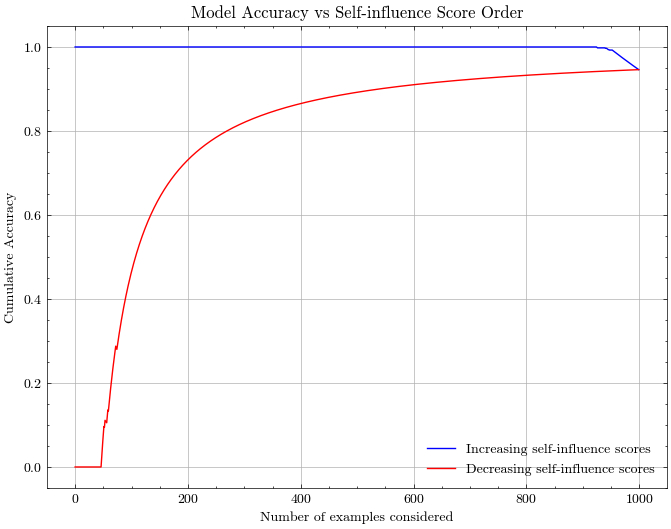

In [34]:
model.to(device)
checkpoints_load_func(model=model, checkpoint_path=checkpoint_paths[0], device=device)
model.eval()

train_predicted: list[bool] = []

with torch.no_grad():
    for idx in tqdm(sorted_score_indices, desc='Calculating accuracies for train ', unit=' samples', total=len(sorted_score_indices)):
        image, label = train_dataset[idx]
        images = image.unsqueeze(0).to(device)
        labels = torch.tensor([label], device=device, dtype=torch.int64)

        logits = model(images)
        predictions = logits.argmax(dim=1)
        train_predicted.extend((predictions == labels).tolist())

train_accuracy = sum(train_predicted) / len(train_predicted)
logger.info(f'Train accuracy for {len(sorted_score_indices)} samples: {train_accuracy:0.4f}')
plot_accuracies(train_predicted)

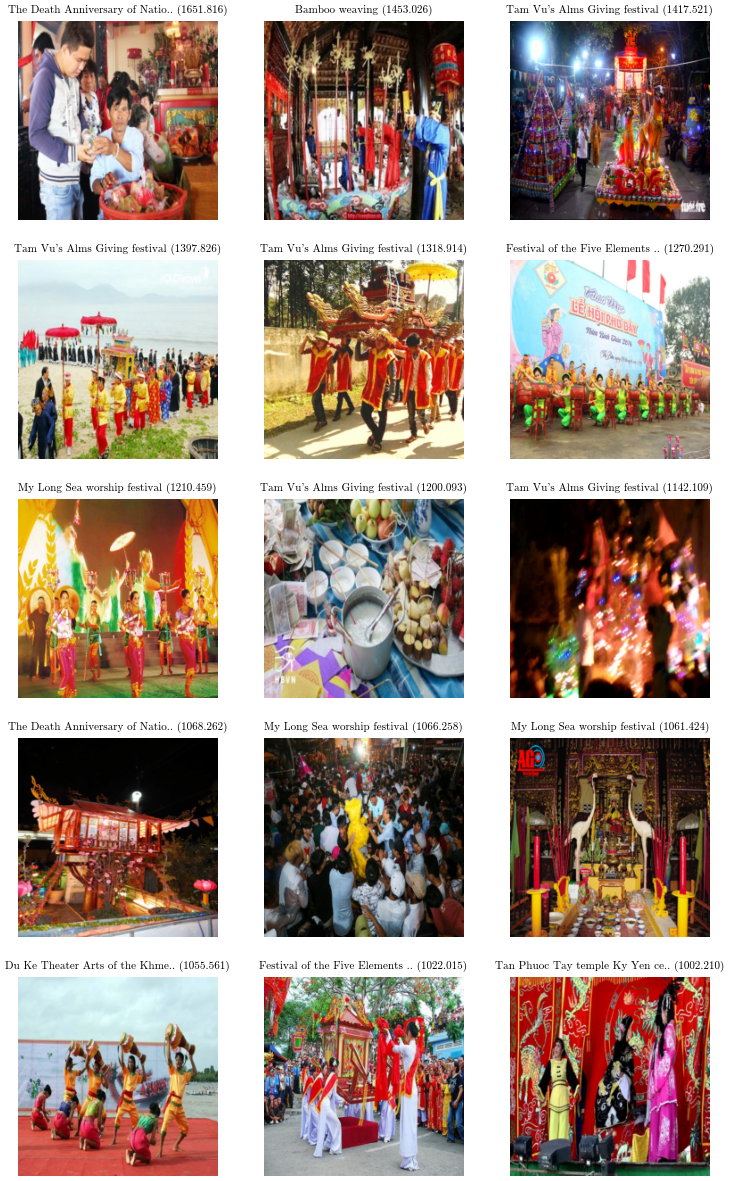

In [81]:
display_label_to_class = label_to_class_full or label_to_class
display_label_to_class = [label[:30] + '..' if len(label) > 30 else label for label in display_label_to_class]

num_train_examples_to_display = 15
train_examples_to_display = [train_dataset[idx] for idx in sorted_score_indices[:num_train_examples_to_display]]
train_examples_self_influence_scores = [self_influence_scores_list[idx] for idx in sorted_score_indices[:num_train_examples_to_display]]

fig = display_images_grid(
    examples=[example[0] for example in train_examples_to_display],
    true_labels=[example[1] for example in train_examples_to_display],
    label_to_class=display_label_to_class,
    max_cols=3,
    self_influence_scores=train_examples_self_influence_scores,
    title_fontsize=8,
)
# fig.savefig('./top_self_influence_train_examples.pdf')

#### Proponents and Opponents

In [16]:
test_features = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
test_labels = torch.tensor([test_dataset[i][1] for i in range(len(test_dataset))], dtype=torch.int64)

In [17]:
k = 7
start_time = datetime.now()
proponents_indices, proponents_influence_scores = tracin_cp_fast.influence(
    inputs=(test_features, test_labels),
    k=k,
    proponents=True,
    show_progress=True,
)
opponents_indices, opponents_influence_scores = tracin_cp_fast.influence(
    inputs=(test_features, test_labels), k=k, proponents=False, show_progress=True
)
total_minutes = (datetime.now() - start_time).total_seconds() / 60.0
print(
    'Computed proponents / opponents over a dataset of %d examples in %.2f minutes'
    % (len(test_dataset), total_minutes)
)

Using TracInCPFast to perform computation for getting proponents. Processing training batches: 100%|██████████████████████████████████████████████| 125/125 [01:13<00:00,  1.71it/s]
Using TracInCPFast to perform computation for getting opponents. Processing training batches: 100%|███████████████████████████████████████████████| 125/125 [01:22<00:00,  1.52it/s]

Computed proponents / opponents over a dataset of 5 examples in 2.60 minutes


In [19]:
test_predicted_labels: list[int] = []
test_predicted_probs: list[float] = []
test_num_totals = 0
test_num_corrects = 0
with torch.no_grad():
    model.to(device)
    checkpoints_load_func(model=model, checkpoint_path=checkpoint_paths[0], device=device)
    model.eval()

    # for idx in tqdm(sorted_score_indices, desc='Calculating accuracies', unit=' samples'):
    test_iter = tqdm(
        test_data_loader,
        desc='Testing model',
    )
    for images, labels in test_iter:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        predictions = logits.argmax(dim=1)
        test_predicted_labels.extend(predictions.tolist())
        test_predicted_probs.extend(logits.softmax(dim=1).max(dim=1).values.tolist())

        test_num_corrects += (predictions == labels).sum().item()
        test_num_totals += labels.shape[0]

test_acccuracy = test_num_corrects / test_num_totals
logger.info(f'Test accuracy on {test_num_totals} samples: {test_acccuracy:0.4f}')

Testing model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]

2025-09-17 20:58:07.411 | INFO     | 282775993:28 - Test accuracy on 5 samples: 1.0000


test example:
true_class: Cai Rang floating market..
predicted_class: Cai Rang floating market..
predicted_prob 0.9865686893463135


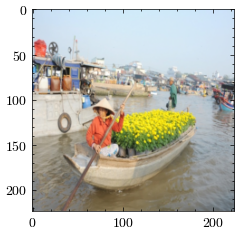

proponents:


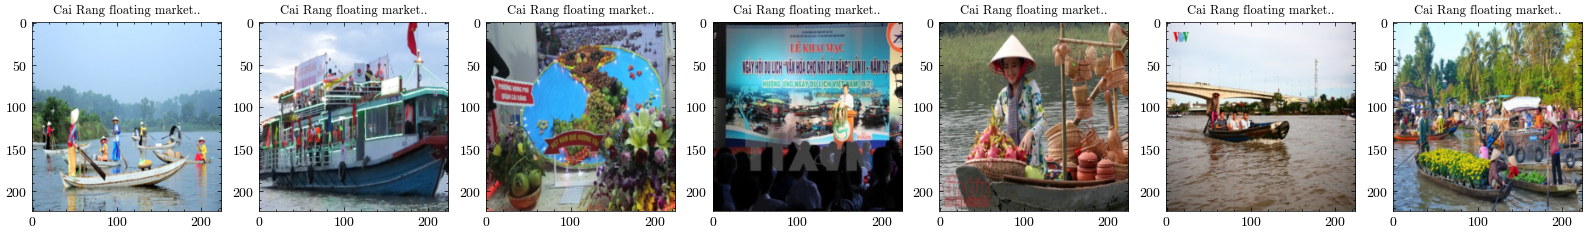

opponents:


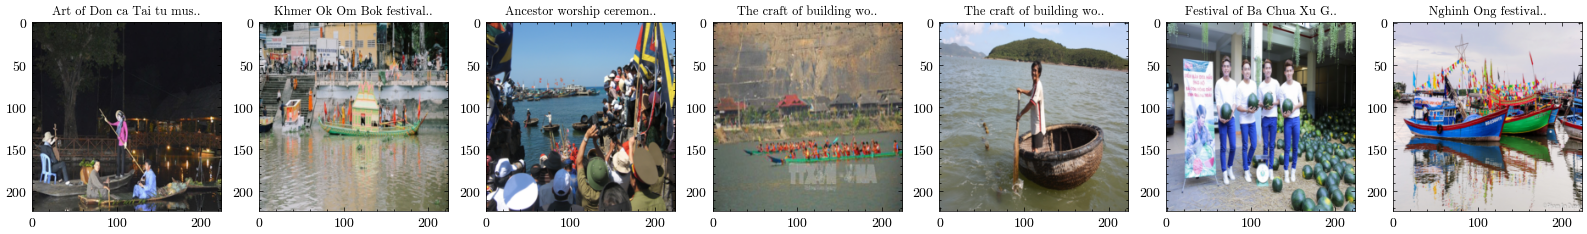

test example:
true_class: Art of Don ca Tai tu mus..
predicted_class: Art of Don ca Tai tu mus..
predicted_prob 0.9733728766441345


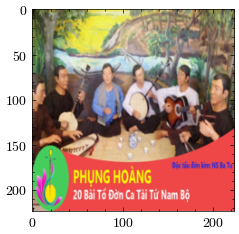

proponents:


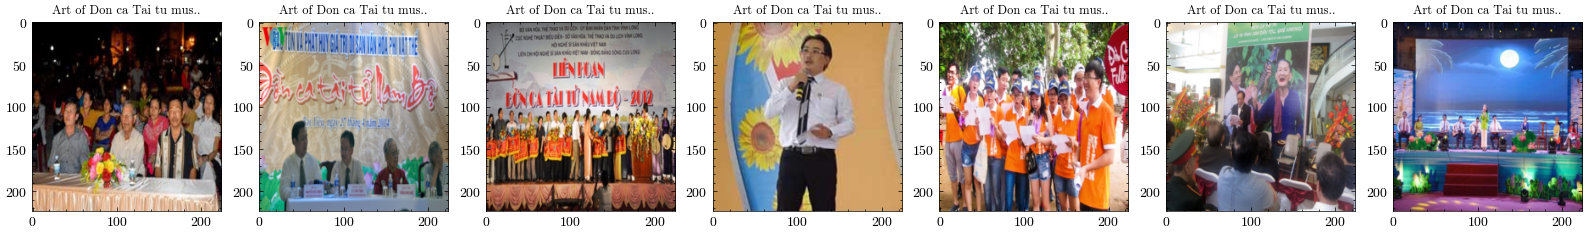

opponents:


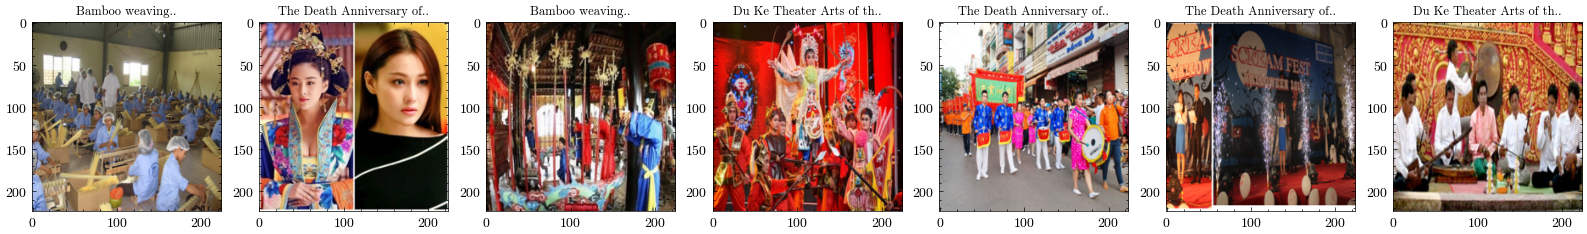

test example:
true_class: Mat weaving..
predicted_class: Mat weaving..
predicted_prob 0.9943671822547913


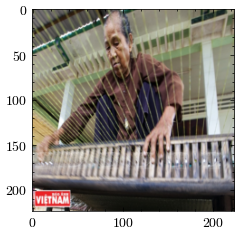

proponents:


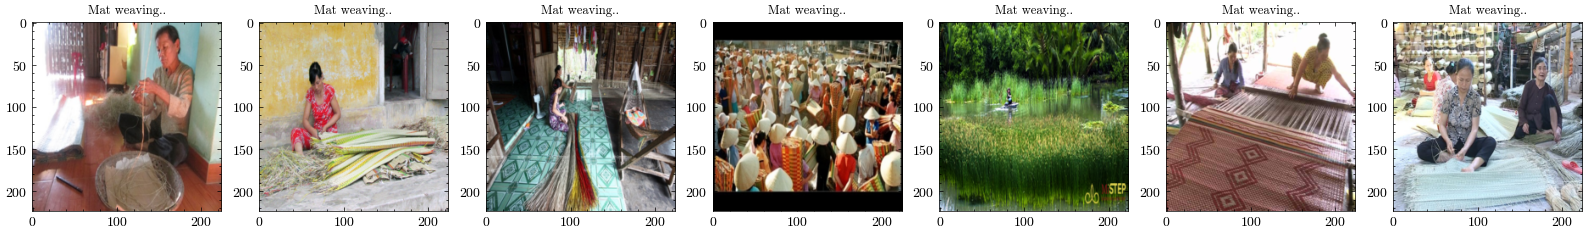

opponents:


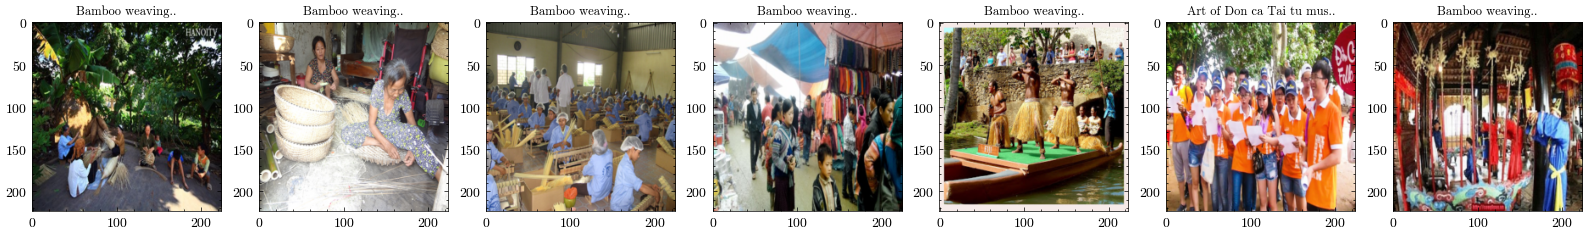

test example:
true_class: Art of Don ca Tai tu mus..
predicted_class: Art of Don ca Tai tu mus..
predicted_prob 0.9777788519859314


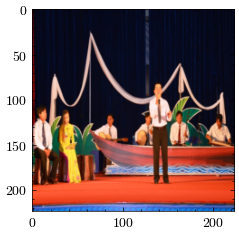

proponents:


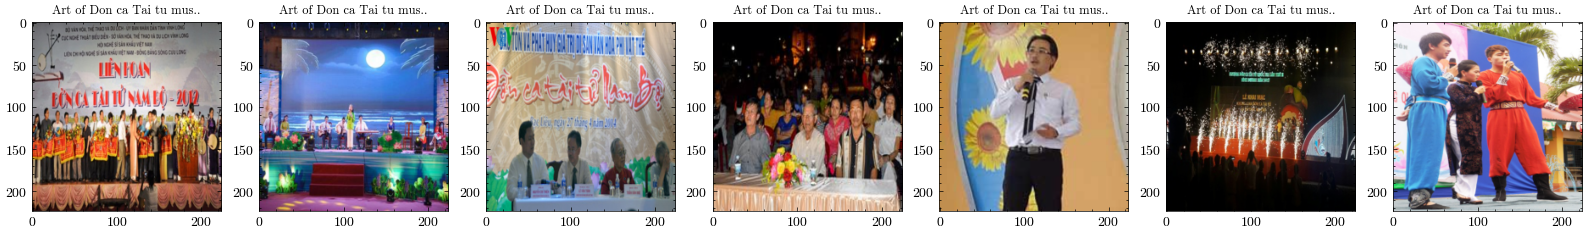

opponents:


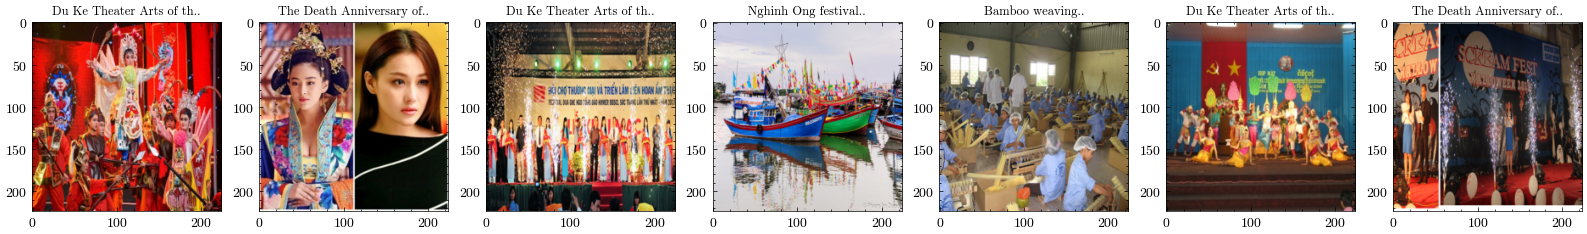

test example:
true_class: Mat weaving..
predicted_class: Mat weaving..
predicted_prob 0.9879130721092224


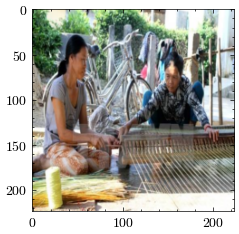

proponents:


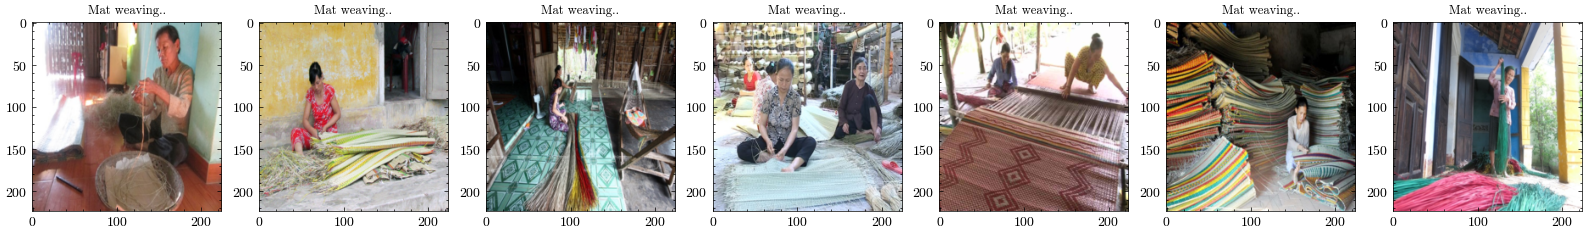

opponents:


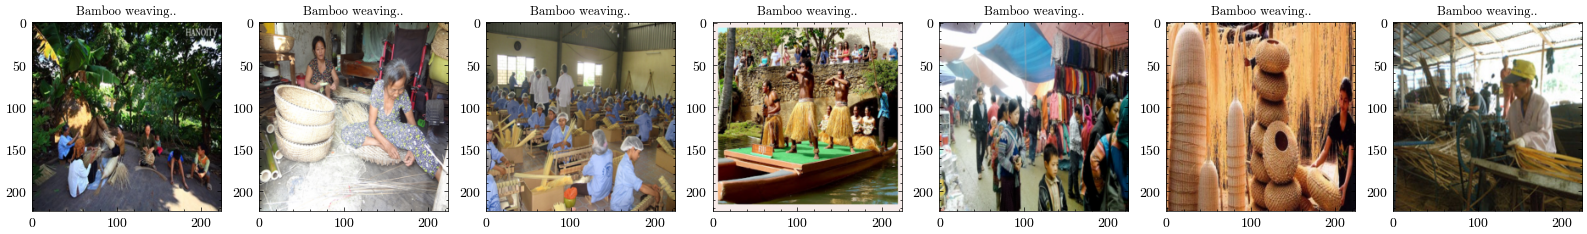

In [27]:
display_label_to_class = label_to_class_full or label_to_class
display_label_to_class = [label[:24] + '..' for label in display_label_to_class]
display_proponents_and_opponents(
    test_examples_batch=test_features,
    proponents_indices=proponents_indices,
    opponents_indices=opponents_indices,
    test_examples_true_labels=test_labels,
    test_examples_predicted_labels=test_predicted_labels,
    test_examples_predicted_probs=test_predicted_probs,
    label_to_class = display_label_to_class,
)